In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelBinarizer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay

## EDA + Preprocessing

In [2]:
df = pd.read_csv('/kaggle/input/dataset-for-predicting-watering-the-plants/TARP.csv')
df.head()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status
0,54,22,70,21,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,ON
1,12,20,40,104,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,OFF
2,34,26,35,62,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,ON
3,7,44,44,93,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,OFF
4,50,38,23,92,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,OFF


In [3]:
encoder = LabelBinarizer()
df['Status'] = encoder.fit_transform(df['Status'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Soil Moisture        100000 non-null  int64  
 1   Temperature          100000 non-null  int64  
 2    Soil Humidity       100000 non-null  int64  
 3   Time                 100000 non-null  int64  
 4   Air temperature (C)  23995 non-null   float64
 5   Wind speed (Km/h)    23995 non-null   float64
 6   Air humidity (%)     23995 non-null   float64
 7   Wind gust (Km/h)     23995 non-null   float64
 8   Pressure (KPa)       23995 non-null   float64
 9   ph                   2200 non-null    float64
 10  rainfall             2200 non-null    float64
 11  N                    2200 non-null    float64
 12  P                    2200 non-null    float64
 13  K                    2200 non-null    float64
 14  Status               100000 non-null  int64  
dtypes: float64(10), in

In [4]:
df.drop_duplicates()
df.drop(['ph', 'rainfall', 'N', 'P' ,'K', 'Time', ' Soil Humidity', 'Temperature', 'Wind speed (Km/h)', 'Wind gust (Km/h)', 'Pressure (KPa)'], axis=1, inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Soil Moisture,100000.0,45.484070,25.993998,1.00,23.00,45.00,68.00,90.00
Air temperature (C),23995.0,24.263780,6.756751,11.22,18.58,22.15,29.59,45.56
Air humidity (%),23995.0,58.521052,30.073448,0.59,33.98,61.31,86.36,96.00
Status,100000.0,0.536500,0.498668,0.00,0.00,1.00,1.00,1.00


In [7]:
imputer = IterativeImputer(random_state=46, verbose=True)
data = imputer.fit_transform(df)
data = pd.DataFrame(data, columns = df.columns)
data.head()

[IterativeImputer] Completing matrix with shape (100000, 4)
[IterativeImputer] Change: 0.16934196909341281, scaled tolerance: 0.096 
[IterativeImputer] Change: 0.10592239345878696, scaled tolerance: 0.096 
[IterativeImputer] Change: 0.06354120574852118, scaled tolerance: 0.096 
[IterativeImputer] Early stopping criterion reached.


,Soil Moisture,Air temperature (C),Air humidity (%),Status
0,54.0,19.52,55.04,1.0
1,12.0,19.49,55.17,0.0
2,34.0,19.47,55.30,1.0
3,7.0,19.54,54.20,0.0
4,50.0,19.61,53.09,0.0


In [8]:
scaler = StandardScaler()
sdf = scaler.fit_transform(data.iloc[:,:-1], data.iloc[:,-1])
scaled_df = pd.DataFrame(sdf, columns = data.iloc[:,:-1].columns)
scaled_df['Status'] = data['Status']
scaled_df.head()

,Soil Moisture,Air temperature (C),Air humidity (%),Status
0,0.327613,-1.433092,-0.236374,1.0
1,-1.288153,-1.442156,-0.227549,0.0
2,-0.441799,-1.448198,-0.218725,1.0
3,-1.480506,-1.427050,-0.293393,0.0
4,0.173731,-1.405901,-0.368741,0.0


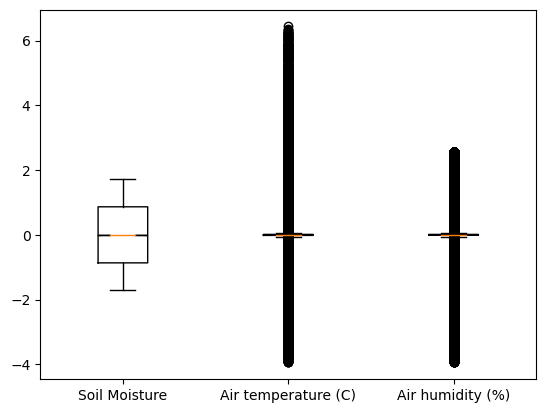

In [10]:
plt.boxplot(scaled_df.iloc[:,:-1], notch=True, labels = scaled_df.iloc[:,:-1].columns, )
plt.show()

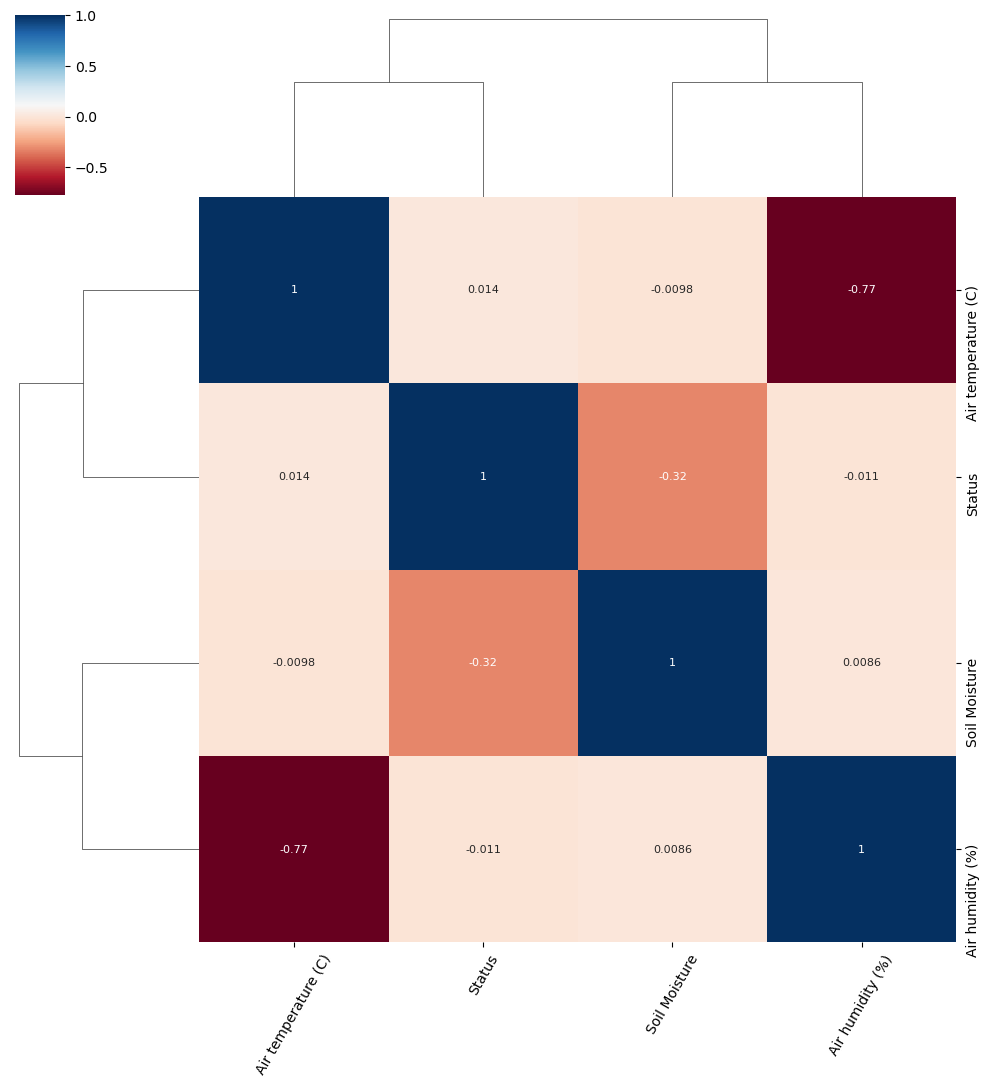

In [11]:
g = sns.clustermap(scaled_df.corr(), 
                   method = 'complete', 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

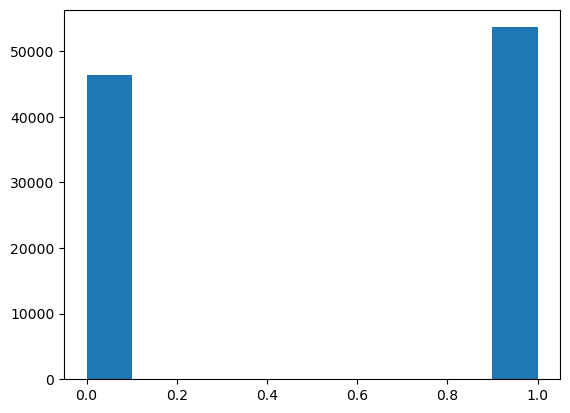

In [15]:
plt.hist(scaled_df['Status'])
plt.show()

## VIF

In [14]:
vif_data = pd.DataFrame()
vif_data["feature"] = scaled_df.iloc[:,:-1].columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(scaled_df.iloc[:,:-1].values, i)
                          for i in range(len(scaled_df.iloc[:,:-1].columns))]
  
print(vif_data)

               feature       VIF
0        Soil Moisture  1.000099
1  Air temperature (C)  2.500294
2     Air humidity (%)  2.500241


## Logistic Regression

In [16]:
x = scaled_df.iloc[:,:-1]
y = scaled_df.iloc[:,-1]

In [17]:
clf = LogisticRegression(random_state=42)
cv = KFold(random_state=42, shuffle=True)
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 
              'C': [0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0], 
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'l1_ratio': [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]}
search = HalvingGridSearchCV(clf, param_grid, cv = cv, random_state=42, 
                             scoring = 'f1', 
                             verbose=3).fit(x, y)
print(search.best_params_)
print(search.best_score_) 

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 137
max_resources_: 100000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 756
n_resources: 137
Fitting 5 folds for each of 756 candidates, totalling 3780 fits
[CV 1/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=liblinear;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END C=0.0001, l1_ratio=0.0, penalty=l1, solver=lib

In [18]:
clf = search.best_estimator_
y_pred = cross_val_predict(clf, x, y, cv=cv)
print(classification_report(y, y_pred, target_names=['ON', 'OFF']))

              precision    recall  f1-score   support

          ON       0.63      0.58      0.60     46350
         OFF       0.66      0.70      0.68     53650

    accuracy                           0.64    100000
   macro avg       0.64      0.64      0.64    100000
weighted avg       0.64      0.64      0.64    100000



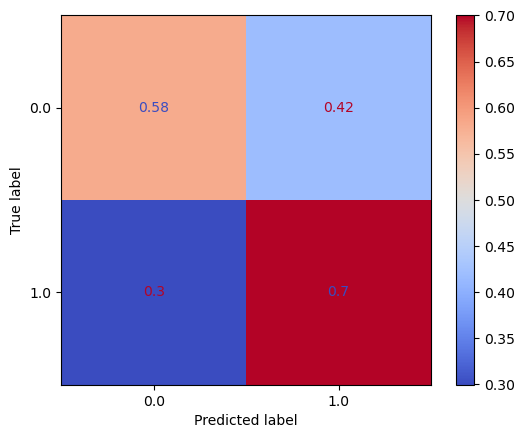

In [19]:
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='coolwarm', normalize = 'true')
plt.show()

In [20]:
coef_str = " + ".join(f"{coef:.4f} * x{i}" for i, coef in enumerate(clf.coef_[0]))
intercept_str = f"{clf.intercept_[0]:.4f}"
print(f"logit(p) = {intercept_str} + {coef_str}")

logit(p) = 0.1630 + -0.6874 * x0 + 0.0236 * x1 + 0.0000 * x2


p = 1 / (1 + e^(-logit(p)))

## Tuning

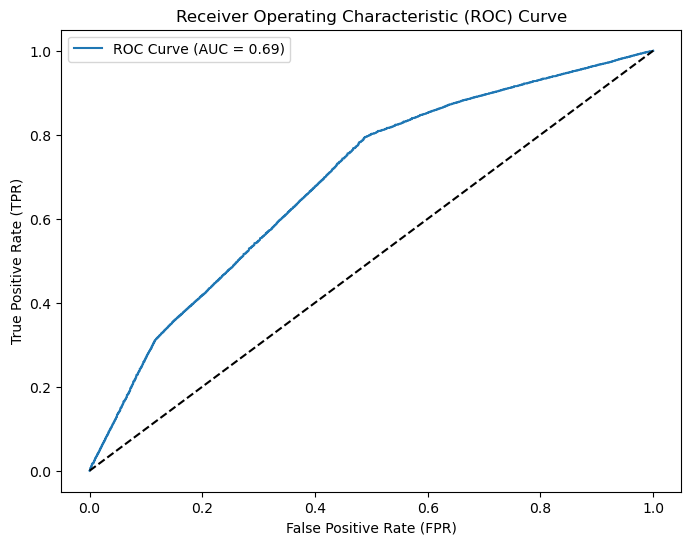

Optimal Threshold: 0.45


In [21]:
# Predict probabilities of the positive class (class 1)
y_pred_prob = cross_val_predict(clf, x, y, cv=cv, method='predict_proba')[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Find the threshold for the top-left corner of the ROC curve (maximize TPR while keeping FPR low)
# You can choose other points on the ROC curve depending on your requirements
top_left_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[top_left_idx]

print(f"Optimal Threshold: {round(optimal_threshold, 2)}")

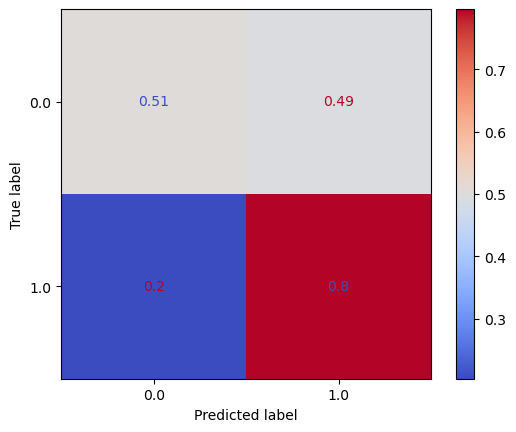

In [22]:
optimal_threshold = 0.45
y_prob = cross_val_predict(clf, x, y, cv=cv, method='predict_proba')
y_pred = (y_prob[:, 1] >= optimal_threshold).astype(int)

# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', cmap='coolwarm')

Tuning doesn't bring to optimize results, as the risk is to turn on the water pump when it's not needed.